In [304]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import shap
import xgboost
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import PandasTools
from rdkit import DataStructs
from rdkit import RDConfig
from sklearn.cluster import DBSCAN
from sklearn import decomposition
from sklearn import datasets 
from sklearn.datasets import make_regression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

#Support_Vector_Machine 
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier 
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

import comptox_ai
import pandas as pd
from comptox_ai.db import GraphDB

In [305]:
db = GraphDB(hostname="neo4j.comptox.ai")
def make_qsar_dataset(chemical_list, assay_abbreviation):
    querystr = """
    MATCH (cl:ChemicalList {{ listAcronym: "{0}" }})-[r1:LISTINCLUDESCHEMICAL]->(c:Chemical)-[r2]->(a:Assay {{ commonName: "{1}" }})
    RETURN
        c.commonName AS chemical,
        c.sMILES AS smiles,
        c.maccs AS maccs,
        CASE TYPE(r2)
          WHEN 'CHEMICALHASINACTIVEASSAY' THEN 0
          WHEN 'CHEMICALHASACTIVEASSAY' THEN 1
          ELSE 2
        END as active;
    """
    res = db.run_cypher(querystr.format(chemical_list, assay_abbreviation))
    print("INFO: Number of chemicals in dataset:", len(res))
    if len(res) < 500:
        print("This might not be enough chemicals to train a model - you should consider generating a different dataset instead.")
    print()

    dset = pd.DataFrame(res)

    return dset[dset['maccs'].notna()]

# Endocrine Disrupting Chemicals w/ Estrogen Receptor Beta 

In [306]:
#Dataset
chemicals = pd.read_csv("endocrine_dataset_with_namess.csv")
smiles_map = pd.read_csv("endocrine_chemicals (2).csv")
chemicals_with_smiles = chemicals.merge(right=smiles_map, how='left', left_on='preferredName', right_on='commonName')
#Converting MACCS Keys into X
col1 = chemicals['maccs']
col1
chemicals_data_as_integers = []
for row in col1:
    try:
        row_as_integers = [int(bit) for bit in str(row)]
        chemicals_data_as_integers.append(row_as_integers)
    except:
        pass    
X1 =np.array(chemicals_data_as_integers, dtype=int)
y1 = chemicals.y.to_numpy()
# Test/Train Split 1
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, stratify=y1)
print(X_train1.shape)
print(X_test1.shape)
print(y_train1.shape)
print(y_test1.shape)
#Validation
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(X_train1, y_train1, train_size=0.9)
print(X_train1.shape)
print(X_test1.shape)
print(X_valid1.shape)
#algorithm 
model_CNB1 = CategoricalNB()
model_CNB.fit(X_train1, y_train1)
CNB_y_pred1 = model_CNB.predict(X_test1)
CNB_accuracy1 = balanced_accuracy_score(y_test1, CNB_y_pred1)
CNB_accuracy1

(3121, 166)
(781, 166)
(3121,)
(781,)
(2808, 166)
(781, 166)
(313, 166)


0.7517331568664525

# Hazardous Substances with Kidney Assay 

In [307]:
#Dataset
Hazardous_dataset = make_qsar_dataset("HSDB2019", "tox21-pr-bla-antagonist-p1") #Kidneys
# Converting MACCS Keys into X
col2 = Hazardous_dataset['maccs']
X2 = list(Hazardous_dataset['maccs'])
X_transformed2 = []
for xx in X:
    X_transformed2.append([int(xxx) for xxx in xx])
Hazardous_dataset_as_integers = []
for row in col2:
    try:
        row_as_integers = [int(bit) for bit in str(row)]
        Hazardous_dataset_as_integers.append(row_as_integers)
    except:
        pass
    
X2 =np.array(Hazardous_dataset_as_integers, dtype=int)
y1 = Hazardous_dataset.active
#Test/Train Split 
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, stratify=y2)
print(X_train2.shape)
print(X_test2.shape)
print(y_train2.shape)
print(y_test2.shape)
#Validation
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_train2, y_train2, train_size=0.9)
print(X_train2.shape)
print(X_test2.shape)
print(X_valid2.shape)
#Algorithm 
model_CNB2 = CategoricalNB()  #CNB had the highest balanced accuracy score 
model_CNB2.fit(X_train2, y_train2)
CNB_y_pred2 = model_CNB2.predict(X_test2)
CNB_accuracy2 = balanced_accuracy_score(y_test2, CNB_y_pred2)
CNB_accuracy2

INFO: Number of chemicals in dataset: 2363

(1886, 166)
(472, 166)
(1886,)
(472,)
(1697, 166)
(472, 166)
(189, 166)


0.713633257812781

# *Hazardous Substances with Colon Cancer Assay 

In [308]:
#Dataset 
Hazardous_dataset2 = make_qsar_dataset("HSDB2019", "tox21-p53-bla-p1") #colon cancer 
# Converting MACCS Keys into X
col3 = Hazardous_dataset2['maccs']
X3 = list(Hazardous_dataset2['maccs'])
X_transformed3 = []
for xx in X3:
    X_transformed3.append([int(xxx) for xxx in xx])
Hazardous_dataset2_as_integers = []
for row in col3:
    try:
        row_as_integers = [int(bit) for bit in str(row)]
        Hazardous_dataset2_as_integers.append(row_as_integers)
    except:
        pass
    
X3 =np.array(Hazardous_dataset2_as_integers, dtype=int)
y3= Hazardous_dataset2.active
#Test/Train Split 
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, stratify=y3)
print(X_train3.shape)
print(X_test3.shape)
print(y_train3.shape)
print(y_test3.shape)
#Validation
X_train3, X_valid3, y_train3, y_valid3 = train_test_split(X_train3, y_train3, train_size=0.9)
print(X_train3.shape)
print(X_test3.shape)
print(X_valid3.shape)
#Algorithm
model_CNB3 = CategoricalNB()  #highest balanced accuracy score 
model_CNB3.fit(X_train3, y_train3)
CNB_y_pred3 = model_CNB3.predict(X_test3)
CNB_accuracy3 = balanced_accuracy_score(y_test3, CNB_y_pred3)
CNB_accuracy3

INFO: Number of chemicals in dataset: 2503

(1998, 166)
(500, 166)
(1998,)
(500,)
(1798, 166)
(500, 166)
(200, 166)


0.6560105363984674

# *Food Contact Chemicals with liver assay

In [309]:
#Dataset
Lfood_dataset = make_qsar_dataset("FOODCONTACTSDB", "tox21-are-bla-p1") # liver
# Converting MACCS Keys into X
col4 = Lfood_dataset['maccs']
X4 = list(Lfood_dataset['maccs'])
X_transformed4 = []
for xx in X4:
    X_transformed4.append([int(xxx) for xxx in xx])
Lfood_dataset_as_integers = []
for row in col4:
    try:
        row_as_integers = [int(bit) for bit in str(row)]
        Lfood_dataset_as_integers.append(row_as_integers)
    except:
        pass
    
X4 =np.array(Lfood_dataset_as_integers, dtype=int)
y4 = Lfood_dataset.active
#Test/Train Split 
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.2, stratify=y4)
print(X_train4.shape)
print(X_test4.shape)
print(y_train4.shape)
print(y_test4.shape)
#Validation
X_train4, X_valid4, y_train4, y_valid4 = train_test_split(X_train4, y_train4, train_size=0.9)
print(X_train4.shape)
print(X_test4.shape)
print(X_valid4.shape)
#Algorithm 
model = RandomForestClassifier(n_estimators=150,max_depth=20,criterion="entropy") # highest balanced accuracy score 
model.fit(X_train4, y_train4)
RFC_y_pred = model.predict(X_test4)
RF_accuracy = balanced_accuracy_score(y_test4, RFC_y_pred)
RF_accuracy

INFO: Number of chemicals in dataset: 1605

(1284, 166)
(321, 166)
(1284,)
(321,)
(1155, 166)
(321, 166)
(129, 166)


0.6497790404040404

# *Skin and Eyes Irritants

In [310]:
# Dataset
dataset = make_qsar_dataset("GHSEYESKIN", "tox21-pxr-p1") #Liver
# Converting MACCS Keys into X
col5 = dataset['maccs']
X5 = list(dataset['maccs'])
X_transformed5 = []
for xx in X5:
    X_transformed5.append([int(xxx) for xxx in xx])
dataset_data_as_integers = []
for row in col5:
    try:
        row_as_integers = [int(bit) for bit in str(row)]
        dataset_data_as_integers.append(row_as_integers)
    except:
        pass
    
X5 =np.array(dataset_data_as_integers, dtype=int)
y5 = dataset.active
#Test/Train Split 
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.2, stratify=y5)
print(X_train5.shape)
print(X_test5.shape)
print(y_train5.shape)
print(y_test5.shape)
#Validation
X_train5, X_valid5, y_train5, y_valid5 = train_test_split(X_train5, y_train5, train_size=0.9)
print(X_train5.shape)
print(X_test5.shape)
print(X_valid5.shape)
# Algorithm 
model_XGB = XGBClassifier(n_estimators=150,max_depth=20) # highest balanced accuracy score 
model.fit(X_train5, y_train5)
XGB_y_pred5 = model.predict(X_test5)
XGBoost_accuracy = balanced_accuracy_score(y_test5, XGB_y_pred5)
XGBoost_accuracy

INFO: Number of chemicals in dataset: 2942

(2349, 166)
(588, 166)
(2349,)
(588,)
(2114, 166)
(588, 166)
(235, 166)


0.7731822296616394

In [297]:
X5 = list(dataset['maccs'])
X_transformed5 = []
for xx in X5:
    X_transformed5.append([int(xxx) for xxx in xx])

In [208]:
dataset[dataset['maccs'].notna()]

,chemical,smiles,maccs,active
0,o-Phenolsulfonic acid,OC1=CC=CC=C1S(O)(=O)=O,0000000000000000000000000000000000000011000000...,0
1,Acetaminophen,CC(=O)NC1=CC=C(O)C=C1,0000000000000000000000000000000000000000000000...,0
2,Acrylonitrile,C=CC#N,0000000000000000000000000000000001000000100000...,0
3,Acrolein,C=CC=O,0000000000000000000000000000000001000000000000...,0
4,2-Amino-4-nitrophenol,NC1=C(O)C=CC(=C1)[N+]([O-])=O,0000000000000000000000010000000000000000000000...,0
...,...,...,...,...
2937,Chlorexolone,NS(=O)(=O)C1=CC2=C(CN(C3CCCCC3)C2=O)C=C1Cl,0000000000000000000000000000000110000000000000...,1
2938,Normethadone,CCC(=O)C(CCN(C)C)(C1=CC=CC=C1)C1=CC=CC=C1,0000000000000000000000000000000000000000000000...,1
2939,4'-Tert-butyl-4-chlorobutyrophenone,CC(C)(C)C1=CC=C(C=C1)C(=O)CCCCl,0000000000000000000000000000000000000000000000...,1
2940,Fenbutrazate,CCC(C(=O)OCCN1CCOC(C1C)C1=CC=CC=C1)C1=CC=CC=C1,0000000000000000000000000000000000000000000000...,1


In [209]:
dataset_data_as_integers = []
for row in col5:
    try:
        row_as_integers = [int(bit) for bit in str(row)]
        dataset_data_as_integers.append(row_as_integers)
    except:
        pass
    
X5 =np.array(dataset_data_as_integers, dtype=int)

X5

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0]])

In [210]:
y5 = dataset.active

# Feature Names

In [314]:
file = open("chemical_features.txt", 'r')
feature_names = [x.strip() for x in
                 file.readlines()]
print(feature_names)
file.close()

['ISOTOPE', 'atomic number > 103', 'Group IVa,Va,VIa Rows 4-6', 'actinide', 'Group IIIB,IVB (Sc...)', 'Lanthanide', 'Group VB,VIB,VIIB', 'QAAA@1', 'Group VIII (Fe...)', 'Group IIa (Alkaline earth)', '4M Ring', 'Group IB,IIB (Cu..)', 'ON(C)C', 'S-S', 'OC(O)O', 'QAA@1', 'CTC', 'Group IIIA (B...)', '7M Ring', 'Si', 'C=C(Q)Q', '3M Ring', 'NC(O)O', 'N-O', 'NC(N)N', 'C$=C($A)$A', 'I', 'QCH2Q', 'P', 'CQ(C)(C)A', 'QX', 'CSN', 'NS', 'CH2=A', 'Group IA (Alkali Metal)', 'S Heterocycle', 'NC(O)N', 'NC(C)N', 'OS(O)O', 'S-O', 'CTN', 'F', 'QHAQH', 'OTHER', 'C=CN', 'BR', 'SAN', 'OQ(O)O', 'CHARGE', 'C=C(C)C', 'CSO', 'NN', 'QHAAAQH', 'QHAAQH', 'OSO', 'ON(O)C', 'O Heterocycle', 'QSQ', 'Snot%A%A', 'S=O', 'AS(A)A', 'A$!A$A', 'N=O', 'A$A!S', 'C%N', 'CC(C)(C)A', 'QS', 'QHQH (&...)', 'QQH', 'QNQ', 'NO', 'OAAO', 'S=A', 'CH3ACH3', 'A!N$A', 'C=C(A)A', 'NAN', 'C=N', 'NAAN', 'NAAAN', 'SA(A)A', 'ACH2QH', 'QAAAA@1', 'NH2', 'CN(C)C', 'CH2QCH2', 'X!A$A', 'S', 'OAAAO', 'QHAACH2A', 'QHAAACH2A', 'OC(N)C', 'QCH3', 'QN', '

# ROC Curve 

In [315]:
from sklearn.metrics import roc_curve, roc_auc_score

In [316]:
#Categorical Naive Bayes 
cnb1 = CategoricalNB()
cnb1.fit(X_train1, y_train1)
cnb_y_pred1 = cnb1.predict(X_test1)
cnb_y_proba1 = cnb1.predict_proba(X_test1)[:,1]

print(balanced_accuracy_score(y_test1, cnb_y_pred1))

0.7517331568664525


In [317]:
#Categorical Naive Bayes 
cnb2 = CategoricalNB()
cnb2.fit(X_train2, y_train2)
cnb_y_pred2 = cnb2.predict(X_test2)
cnb_y_proba2 = cnb2.predict_proba(X_test2)[:,1]

print(balanced_accuracy_score(y_test2, cnb_y_pred2))

0.713633257812781


In [318]:
#Categorical Naive Bayes 
cnb3 = CategoricalNB()
cnb3.fit(X_train3, y_train3)
cnb_y_pred3 = cnb3.predict(X_test3)
cnb_y_proba3 = cnb3.predict_proba(X_test3)[:,1]

print(balanced_accuracy_score(y_test3, cnb_y_pred3))

0.6560105363984674


In [319]:
#Random Forest Classifier
rf4 = RandomForestClassifier()
rf4.fit(X_train4, y_train4)
rf_y_pred4 = rf4.predict(X_test4)
rf_y_proba4 = rf4.predict_proba(X_test4)[:,1]

print(balanced_accuracy_score(y_test4, rf_y_pred4))

0.6346275252525253


In [320]:
#XGBoost 
model_XGB = XGBClassifier(n_estimators=150,max_depth=20)
model.fit(X_train5, y_train5)
XGB_y_pred = model.predict(X_test5)
XGB_y_proba = model.predict_proba(X_test5)[:,1]

print(balanced_accuracy_score(y_test5, XGB_y_pred))

0.7874442755393103


In [321]:
roc_list = []

cnb1_roc_fpr, cnb1_roc_tpr, _ = roc_curve(y_test1, cnb_y_proba1)
cnb1_roc_auc = roc_auc_score(y_test1, cnb_y_proba1)
cnb1_label = 'EDC vs. ER\n(AUC=' + str(round(cnb1_roc_auc, 2)) + ')'

cnb2_roc_fpr, cnb2_roc_tpr, _ = roc_curve(y_test2, cnb_y_proba2)
cnb2_roc_auc = roc_auc_score(y_test2, cnb_y_proba2)
cnb2_label = 'HS vs. K\n(AUC=' + str(round(cnb2_roc_auc, 2)) + ')'

cnb3_roc_fpr, cnb3_roc_tpr, _ = roc_curve(y_test3, cnb_y_proba3)
cnb3_roc_auc = roc_auc_score(y_test3, cnb_y_proba3)
cnb3_label = 'HS vs. CC\n(AUC=' + str(round(cnb3_roc_auc, 2)) + ')'

rf4_roc_fpr, rf4_roc_tpr, _ = roc_curve(y_test4, rf_y_proba4)
rf4_roc_auc = roc_auc_score(y_test4, rf_y_proba4)
rf4_label = 'FCC vs. L\n(AUC=' + str(round(rf4_roc_auc, 2)) + ')'
 
XGB_roc_fpr, XGB_roc_tpr, _ = roc_curve(y_test5, XGB_y_proba)
XGB_roc_auc = roc_auc_score(y_test5, XGB_y_proba)
XGB_label = 'SEI vs. L\n(AUC=' + str(round(XGB_roc_auc, 2)) + ')'


roc_list.append((cnb1_roc_fpr, cnb1_roc_tpr, cnb1_label))
roc_list.append((cnb2_roc_fpr, cnb2_roc_tpr, cnb2_label))
roc_list.append((cnb3_roc_fpr, cnb3_roc_tpr, cnb3_label))
roc_list.append((rf4_roc_fpr, rf4_roc_tpr, rf4_label))
roc_list.append((XGB_roc_fpr,XGB_roc_tpr,XGB_label))

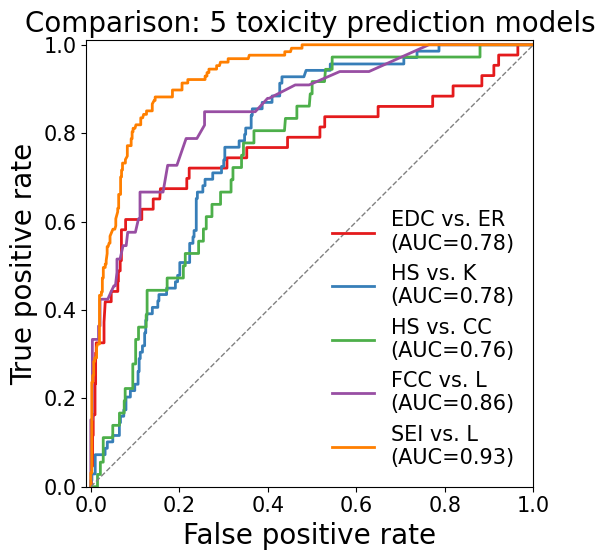

In [322]:
# Make plot

plot_color = [plt.cm.Set1(0), plt.cm.Set1(1), plt.cm.Set1(2), plt.cm.Set1(3), plt.cm.Set1(4)]

plt.figure(figsize=(6,6))

plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)

# Here's where we plot the actual curves
for nrl in range(0, len(roc_list)):
    rl = roc_list[nrl]
    rl_fpr, rl_tpr, rl_label = rl
    if nrl < len(plot_color):
        plt.plot(rl_fpr, rl_tpr, lw=2, label=rl_label, color=plot_color[nrl])

# Plot the dashed line
plt.plot([0,1], [0,1], color='grey', lw=1, linestyle='--')

# Add other graphical elements
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Comparison: 5 toxicity prediction models')
plt.legend(loc='lower right', frameon = False)
plt.tight_layout()
plt.savefig('./roc_plot.pdf')